In [1]:
import random

import pandas as pd
import numpy as np

from pyspark import SparkConf
from pyspark.sql import SparkSession

from replay.session_handler import State
# from sim4rec.utils import State
from sim4rec.utils import pandas_to_spark

SPARK_LOCAL_DIR = './tmp'
CHECKPOINT_DIR = './tmp/checkpoints'

spark = SparkSession.builder\
    .appName('simulator')\
    .master('local[4]')\
    .config('spark.sql.shuffle.partitions', '4')\
    .config('spark.default.parallelism', '4')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '4g')\
    .config('spark.local.dir', SPARK_LOCAL_DIR)\
    .getOrCreate()

State(spark)

np.random.seed(1234)

users_df = pd.DataFrame(data=np.random.normal(1, 1, size=(10000, 35)), columns=[f'user_attr_{i}' for i in range(35)]) 
items_df = pd.DataFrame(data=np.random.normal(-1, 1, size=(2000, 35)), columns=[f'item_attr_{i}' for i in range(35)]) 
items_df.loc[random.sample(range(2000), 1000)] = np.random.normal(1, 1, size=(1000, 35))
users_df['user_id'] = np.arange(len(users_df))
items_df['item_id'] = np.arange(len(items_df))
history_df_all = pd.DataFrame()
history_df_all['user_id'] = np.random.randint(0, 10000, size=33000)
history_df_all['item_id'] = np.random.randint(0, 2000, size=33000)
history_df_all['relevance'] = 0

users_matrix = users_df.values[history_df_all.values[:, 0], :-1]
items_matrix = items_df.values[history_df_all.values[:, 1], :-1]
dot = np.sum(users_matrix * items_matrix, axis=1)
history_df_all['relevance'] = np.where(dot >= 0.5, 1, 0)
history_df_all = history_df_all.drop_duplicates(subset=['user_id', 'item_id'], ignore_index=True)

history_df_train = history_df_all.iloc[:30000]
history_df_val = history_df_all.iloc[30000:]

users_df = pandas_to_spark(users_df)
items_df = pandas_to_spark(items_df)
history_df_train = pandas_to_spark(history_df_train)
history_df_val = pandas_to_spark(history_df_val)

23/06/08 15:09:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/08 15:09:47 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


## Divide users into strats

In [2]:
import pyspark.sql.functions as sf


## Divide users by half for demostration purposes
users_cluster_1_df = users_df.filter(sf.col('user_id') < 5000)
users_cluster_2_df = users_df.filter(sf.col('user_id') >= 5000)

## Обучение генераторов

In [3]:
import warnings
warnings.filterwarnings("ignore")

from sim4rec.modules import RealDataGenerator, SDVDataGenerator, CompositeGenerator
from sim4rec.modules import evaluate_synthetic

generator_1 = SDVDataGenerator(
    label='synth_strat_1',
    id_column_name='user_id',
    model_name='gaussiancopula',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)
generator_2 = SDVDataGenerator(
    label='synth_strat_2',
    id_column_name='user_id',
    model_name='gaussiancopula',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

items_generator = RealDataGenerator(label='items_real', seed=1234)

generator_1.fit(users_cluster_1_df.drop('user_id'))
generator_2.fit(users_cluster_2_df.drop('user_id'))
items_generator.fit(items_df)

for g, d in zip([generator_1, generator_2], [users_cluster_1_df, users_cluster_2_df]):
    print(g.getLabel(), evaluate_synthetic(g.generate(d.count()).drop('user_id'), d.drop('user_id')))

users_com_generator = CompositeGenerator(
    generators=[generator_1, generator_2],
    label='users_composite',
    weights=[0.5, 0.5]
)
users_com_generator.generate(10000)

23/06/08 15:11:47 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


synth_strat_1 {'LogisticDetection': 1.0, 'SVCDetection': 0.8839081024111148, 'KSTest': 0.9855257142857143, 'ContinuousKLDivergence': 0.9671574151768041}


synth_strat_2 {'LogisticDetection': 1.0, 'SVCDetection': 0.8853468242957844, 'KSTest': 0.9846000000000001, 'ContinuousKLDivergence': 0.9670461996009401}


## Simulator initialization

In [4]:
from sim4rec.modules import Simulator

sim = Simulator(
    user_gen=users_com_generator,
    item_gen=items_generator,
    data_dir=f'{CHECKPOINT_DIR}/pipeline',
    user_key_col='user_id',
    item_key_col='item_id',
    spark_session=spark
)

## Response function

In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import PipelineModel
from sim4rec.response import CosineSimilatiry, BernoulliResponse, NoiseResponse, ParametricResponseFunction


va_users = VectorAssembler(
    inputCols=users_df.columns[:-1],
    outputCol='features_usr'
)

va_items = VectorAssembler(
    inputCols=items_df.columns[:-1],
    outputCol='features_itm'
)

cos_sim = CosineSimilatiry(
    inputCols=["features_usr", "features_itm"],
    outputCol="cosine_proba"
)

noise_resp = NoiseResponse(mu=0.5, sigma=0.2, outputCol='noise_proba', seed=1234)

resp_func = ParametricResponseFunction(
    inputCols=['cosine_proba', 'noise_proba'],
    outputCol='proba',
    weights=[1.0, 0.0]
)
br = BernoulliResponse(inputCol='proba', outputCol='response')

cos_sim_model = PipelineModel(
    stages=[
        va_users,
        va_items,
        cos_sim,
        noise_resp,
        resp_func,
        br
    ]
)

In [6]:
from sim4rec.modules import EvaluateMetrics

test_df = history_df_train.join(users_df, 'user_id', 'left')\
                          .join(items_df, 'item_id', 'left')

lr_eval = EvaluateMetrics(
    userKeyCol='user_id',
    itemKeyCol='item_id',
    predictionCol='proba',
    labelCol='relevance',
    mllib_metrics=['areaUnderROC', 'areaUnderPR']
)
lr_eval(cos_sim_model.transform(test_df))

{'areaUnderROC': 0.9999997688888849, 'areaUnderPR': 0.9999997226105108}

## Recommendation algorithm training

In [7]:
from replay.data_preparator import Indexer

indexer = Indexer(user_col='user_id', item_col='item_id')
indexer.fit(users=users_com_generator.sample(1.0), items=items_df)

from replay.models import UCB

model = UCB(sample=True)
model.fit(log=indexer.transform(history_df_train.limit(1)))

23/06/08 15:15:10 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
23/06/08 15:15:10 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
23/06/08 15:15:10 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
23/06/08 15:15:10 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.


In [8]:
from sim4rec.modules import EvaluateMetrics
# from replay.metrics import NDCG, Precision, Recall

evaluator = EvaluateMetrics(
    userKeyCol='user_id',
    itemKeyCol='item_id',
    predictionCol='relevance',
    labelCol='response',
    replay_label_filter=1.0,
    replay_metrics={NDCG() : 10}
)

spark.sparkContext.setLogLevel('ERROR')

In [9]:
import time
# from replay.utils import get_top_k_recs

metrics = []
for i in range(50):
    iter_time = time.time()
    ## sample a bunch of users
    users = sim.sample_users(0.02).cache()

    log = sim.get_log(users)
    if log is None:
        log = history_df_train.limit(1)
    log = log.cache()

    recs = model.predict(
        log=indexer.transform(log),
        k=10,
        users=indexer.transform(users),
        items=indexer.transform(items_df)
    )
    recs = indexer.inverse_transform(recs).cache()

    ## simulate responses on recommended items
    true_resp = sim.sample_responses(
        recs_df=recs,
        user_features=users,
        item_features=items_df,
        action_models=cos_sim_model
    ).select('user_id', 'item_id', 'relevance', 'response').cache()

    ## update log with simulated responses
    sim.update_log(true_resp, iteration=i)

    ## calculate metrics
    metrics.append(evaluator(true_resp))

    ## refit recommendation model
    model._clear_cache()
    train_log = sim.log.cache()
    model.fit(
        log=indexer.transform(
            train_log.select('user_id', 'item_id', 'response')\
                     .withColumnRenamed('response', 'relevance')
        )
    )

    users.unpersist()
    # pairs.unpersist()
    if log is not None:
        log.unpersist()
    recs.unpersist()
    true_resp.unpersist()
    train_log.unpersist()

    print(f'Iteration {i} finished in {time.time() - iter_time} sec.')

Iteration 0 finished in 15.387271881103516 sec.
Iteration 1 finished in 9.601979970932007 sec.
Iteration 2 finished in 8.662182092666626 sec.
Iteration 3 finished in 7.806817054748535 sec.
Iteration 4 finished in 6.580693006515503 sec.
Iteration 5 finished in 6.6706459522247314 sec.
Iteration 6 finished in 6.575250148773193 sec.
Iteration 7 finished in 6.940939903259277 sec.
Iteration 8 finished in 6.5682597160339355 sec.
Iteration 9 finished in 6.562450885772705 sec.
Iteration 10 finished in 6.5772528648376465 sec.
Iteration 11 finished in 6.724180221557617 sec.
Iteration 12 finished in 6.942054986953735 sec.
Iteration 13 finished in 6.655655860900879 sec.
Iteration 14 finished in 7.062520980834961 sec.
Iteration 15 finished in 6.480510950088501 sec.
Iteration 16 finished in 6.40587592124939 sec.
Iteration 17 finished in 7.005590915679932 sec.
Iteration 18 finished in 6.557711839675903 sec.
Iteration 19 finished in 6.39706015586853 sec.
Iteration 20 finished in 6.35417103767395 sec.
I

(0.6, 1.01)

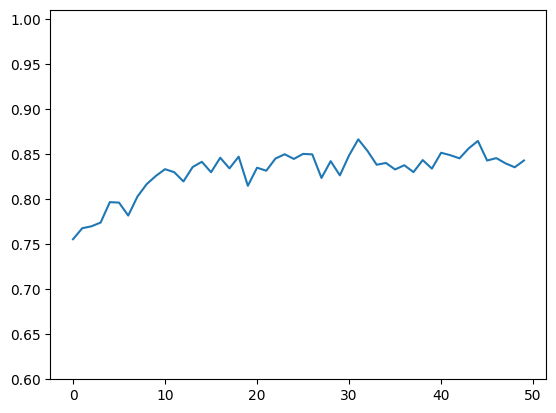

In [10]:
metrics_pdf = pd.DataFrame(metrics)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(metrics_pdf['NDCG@10'])
plt.ylim(0.6, 1.01)